In [1]:
import psycopg2
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt

from config import DB_VISION_ZERO, DB_MOPED
from helper import dict_factory, to_json_list

In [2]:
def get_data(query, cursor):
    """
    Get data from database
    """
    cursor.execute(query)
    data = cursor.fetchall()
    field_names = [i[0] for i in cursor.description]
    df = pd.DataFrame(data, columns=field_names)

    return df

conn_vz = psycopg2.connect(
    dbname = DB_VISION_ZERO['dbname'],
    user = DB_VISION_ZERO["user"],
    host = DB_VISION_ZERO["host"],
    password = DB_VISION_ZERO["password"],
    port=5432
)

conn_moped = psycopg2.connect(
    dbname = DB_MOPED["dbname"],
    user = DB_MOPED["user"],
    host = DB_MOPED["host"],
    password = DB_MOPED["password"],
    port = 5432
)

cursor_vz = conn_vz.cursor()
cursor_moped = conn_moped.cursor()

# Moped processing

In [3]:
# Creating moped dataframe
QUERY_MOPED = """SELECT project_id, project_component_id, geometry, 
line_geometry, substantial_completion_date, 
substantial_completion_date_estimated, completion_date, completion_end_date
FROM component_arcgis_online_view"""

# Creating moped dataframe
df_moped = get_data(QUERY_MOPED, cursor_moped)
df_moped.to_csv('df_moped.csv')  

In [4]:
# Data frame info
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12082 entries, 0 to 12081
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12082 non-null  int64              
 1   project_component_id                   11634 non-null  float64            
 2   geometry                               11634 non-null  object             
 3   line_geometry                          11634 non-null  object             
 4   substantial_completion_date            2852 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  348 non-null    datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    213 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), int64(1), object(2)
memory usage: 755.3+ KB


In [5]:
# Dropping observations where completion end date is not present
df_moped_filter = df_moped.dropna(subset=['substantial_completion_date'])
df_moped_filter.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date
10,12,181.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
11,12,183.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
12,12,469.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
13,12,182.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
14,12,16.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00


In [6]:
df_moped_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2852 entries, 10 to 12076
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2852 non-null   int64              
 1   project_component_id                   2669 non-null   float64            
 2   geometry                               2669 non-null   object             
 3   line_geometry                          2669 non-null   object             
 4   substantial_completion_date            2852 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    181 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), int64(1), object(2)
memory usage: 200.5+ KB


In [7]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["substantial_completion_date",
                     "substantial_completion_date_estimated", 
                     "completion_date", 
                     "completion_end_date"]

for col in timestamp_columns:
    df_moped_filter.loc[:, col] = df_moped_filter[col].astype(str)

# Apply the geometry transformation using .loc
df_moped_filter.loc[:, "geometry"] = df_moped_filter["geometry"].apply(lambda x: shape(x) if x is not None else None)

# Create GeoDataFrame
gdf_moped = gpd.GeoDataFrame(df_moped_filter, geometry="geometry")

In [8]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
12,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
13,12,182.0,MULTIPOINT (-97.73386 30.26657),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00


In [9]:
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12082 entries, 0 to 12081
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12082 non-null  int64              
 1   project_component_id                   11634 non-null  float64            
 2   geometry                               11634 non-null  object             
 3   line_geometry                          11634 non-null  object             
 4   substantial_completion_date            2852 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  348 non-null    datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    213 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), int64(1), object(2)
memory usage: 755.3+ KB


In [10]:
df_moped_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2852 entries, 10 to 12076
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2852 non-null   int64              
 1   project_component_id                   2669 non-null   float64            
 2   geometry                               2669 non-null   object             
 3   line_geometry                          2669 non-null   object             
 4   substantial_completion_date            2852 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    181 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), int64(1), object(2)
memory usage: 200.5+ KB


# VisionZero processing

In [11]:
# Creaing vision zero dataframe
QUERY_CRASH_DATA = """SELECT crash_id, crash_fatal_fl, crash_date, rpt_latitude,
rpt_longitude, road_constr_zone_fl, latitude, longitude, tot_injry_cnt, death_cnt 
FROM atd_txdot_crashes"""

df_vz = get_data(QUERY_CRASH_DATA, cursor_vz)
df_vz.to_csv('df_vz.csv')

In [12]:
df_vz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417945 entries, 0 to 417944
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             417945 non-null  int64  
 1   crash_fatal_fl       417945 non-null  object 
 2   crash_date           417945 non-null  object 
 3   rpt_latitude         62487 non-null   float64
 4   rpt_longitude        62487 non-null   float64
 5   road_constr_zone_fl  417943 non-null  object 
 6   latitude             386519 non-null  float64
 7   longitude            386519 non-null  float64
 8   tot_injry_cnt        417943 non-null  float64
 9   death_cnt            417944 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 31.9+ MB


In [13]:
# Filtering

# Keepiing only those observations where x-y coordinates are present
df_vz_filter = df_vz[df_vz['latitude'].notnull() & df_vz['longitude'].notnull()]

In [14]:
df_vz_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386519 entries, 0 to 417944
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             386519 non-null  int64  
 1   crash_fatal_fl       386519 non-null  object 
 2   crash_date           386519 non-null  object 
 3   rpt_latitude         60310 non-null   float64
 4   rpt_longitude        60310 non-null   float64
 5   road_constr_zone_fl  386519 non-null  object 
 6   latitude             386519 non-null  float64
 7   longitude            386519 non-null  float64
 8   tot_injry_cnt        386519 non-null  float64
 9   death_cnt            386519 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 32.4+ MB


In [15]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["crash_date"]

for col in timestamp_columns:
    df_vz_filter.loc[:, col] = df_vz_filter[col].astype(str)

In [16]:
# Creating geodataframe
gdf_vz = gpd.GeoDataFrame(df_vz_filter,
                          geometry=gpd.points_from_xy(df_vz_filter.longitude,
                                                      df_vz_filter.latitude),
                                                      crs='EPSG:4326')

gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,geometry
0,13118092,N,2013-01-25,NaN,NaN,N,30.430933,-97.700708,1.0,0.0,POINT (-97.70071 30.43093)
1,13118095,N,2013-01-25,NaN,NaN,N,30.241433,-97.728098,0.0,0.0,POINT (-97.72810 30.24143)
2,13110170,N,2013-01-24,NaN,NaN,N,30.377071,-97.739046,0.0,0.0,POINT (-97.73905 30.37707)
3,15735606,N,2017-04-26,NaN,NaN,N,29.884583,-97.924178,0.0,0.0,POINT (-97.92418 29.88458)
4,15536425,N,2015-11-25,NaN,NaN,N,30.413076,-97.690751,2.0,0.0,POINT (-97.69075 30.41308)


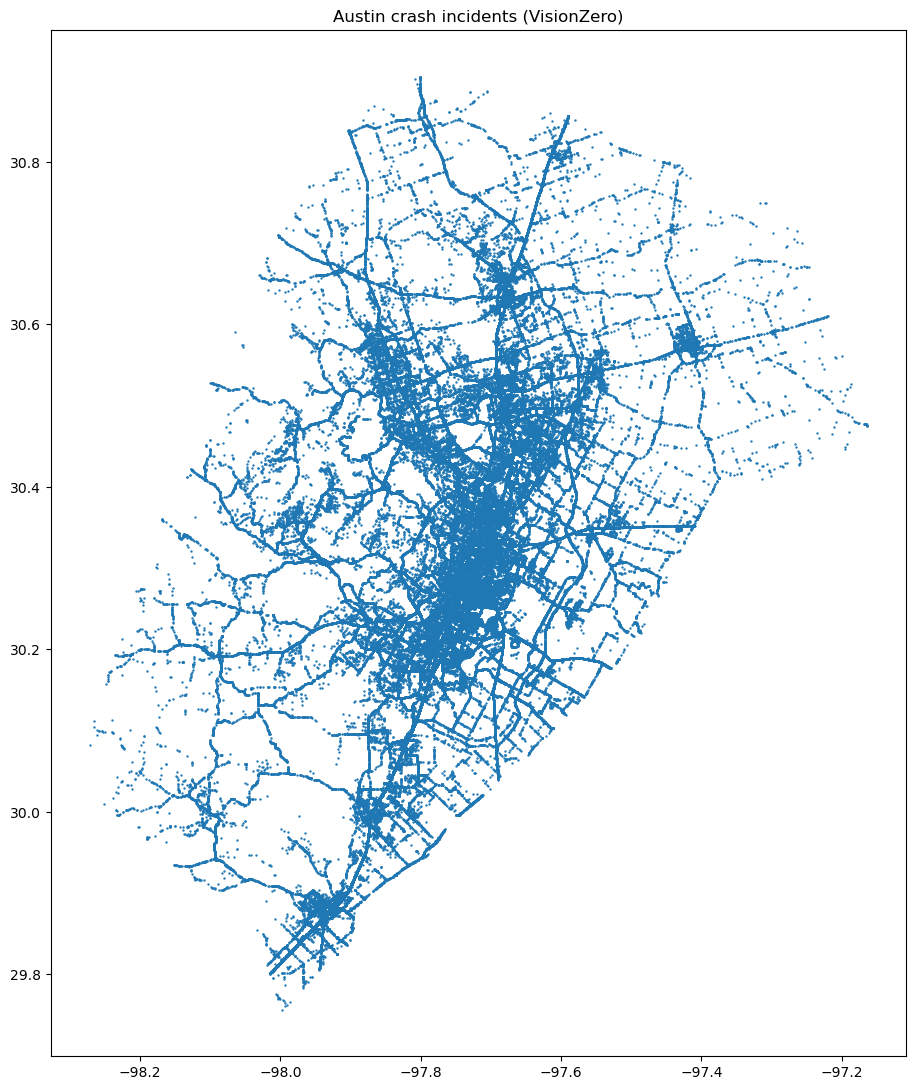

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 13.33))
gdf_vz.plot(ax=ax, markersize=0.5)  
plt.title('Austin crash incidents (VisionZero)')
plt.show()

# Spatial join

In [18]:
gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,geometry
0,13118092,N,2013-01-25,NaN,NaN,N,30.430933,-97.700708,1.0,0.0,POINT (-97.70071 30.43093)
1,13118095,N,2013-01-25,NaN,NaN,N,30.241433,-97.728098,0.0,0.0,POINT (-97.72810 30.24143)
2,13110170,N,2013-01-24,NaN,NaN,N,30.377071,-97.739046,0.0,0.0,POINT (-97.73905 30.37707)
3,15735606,N,2017-04-26,NaN,NaN,N,29.884583,-97.924178,0.0,0.0,POINT (-97.92418 29.88458)
4,15536425,N,2015-11-25,NaN,NaN,N,30.413076,-97.690751,2.0,0.0,POINT (-97.69075 30.41308)


In [19]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
12,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
13,12,182.0,MULTIPOINT (-97.73386 30.26657),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00


In [20]:
gdf_moped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2852 entries, 10 to 12076
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2852 non-null   int64              
 1   project_component_id                   2669 non-null   float64            
 2   geometry                               2669 non-null   geometry           
 3   line_geometry                          2669 non-null   object             
 4   substantial_completion_date            2852 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    181 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), float64(1), geometry(1), int64(1), object(1)
memory usage

In [21]:
# Keeping only those observations where line_geometry is available
gdf_moped = gdf_moped.dropna(subset=['line_geometry'])

In [22]:
# Function to parase line_geometry column in the moped data frame
def parse_linestring(line_geom):

    if line_geom['type'] == 'LineString':
        coordinates = [tuple(coord) for coord in line_geom['coordinates']]
        return LineString(coordinates)
    elif line_geom['type'] == 'MultiLineString':
        lines = [LineString([tuple(coord) for coord in line]) for line in line_geom['coordinates']]
        return MultiLineString(lines)
    else:
        raise ValueError(f"Unexpected geometry type: {line_geom['type']}")

gdf_moped['line_geometry'] = gdf_moped['line_geometry'].apply(parse_linestring)

In [23]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (-97.733436244 30.267508296, -97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"LINESTRING (-97.73422624299999 30.267724297, -...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
12,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...",MULTILINESTRING ((-97.73423324300001 30.267730...,2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
13,12,182.0,MULTIPOINT (-97.73386 30.26657),"LINESTRING (-97.73378324399999 30.266570296, -...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"LINESTRING (-97.734592244 30.266820297, -97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00


In [24]:
# Adding a unique ID column to the moped data frame
gdf_moped.insert(0, 'moped_component_id', range(1, 1 + len(gdf_moped)))

In [25]:
# Creating buffer for joining
gdf_moped = gdf_moped.set_geometry('line_geometry')
gdf_moped.set_crs(epsg=4326, inplace=True)
gdf_moped_proj = gdf_moped.to_crs(epsg=32614)
buffer_distance = 100

gdf_moped_proj = gdf_moped.to_crs(epsg=32614)

In [26]:
gdf_moped_proj['buffered_geometry'] = gdf_moped_proj.geometry.buffer(buffer_distance)
buffered_moped_gdf = gdf_moped_proj.set_geometry('buffered_geometry').to_crs('EPSG:4326')

In [27]:
buffered_moped_gdf.head()

,moped_component_id,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,buffered_geometry
10,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73240 30.26759, -97.73240 30.267..."
11,2,12,183.0,MULTIPOINT (-97.73430 30.26772),"LINESTRING (621756.837 3349129.944, 621756.702...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73319 30.26780, -97.73319 30.267..."
12,3,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","MULTILINESTRING ((621756.156 3349130.601, 6217...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73461 30.26586, -97.73469 30.265..."
13,4,12,182.0,MULTIPOINT (-97.73386 30.26657),"LINESTRING (621800.878 3349002.525, 621800.743...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73275 30.26665, -97.73274 30.266..."
14,5,12,16.0,MULTIPOINT (-97.73467 30.26682),"LINESTRING (621722.743 3349029.365, 621722.609...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,"POLYGON ((-97.73356 30.26690, -97.73355 30.266..."


In [28]:
buffered_moped_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2669 entries, 10 to 12076
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   moped_component_id                     2669 non-null   int64              
 1   project_id                             2669 non-null   int64              
 2   project_component_id                   2669 non-null   float64            
 3   geometry                               2669 non-null   geometry           
 4   line_geometry                          2669 non-null   geometry           
 5   substantial_completion_date            2669 non-null   datetime64[ns, UTC]
 6   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 7   completion_date                        338 non-null    datetime64[ns, UTC]
 8   completion_end_date                    181 non-null    datetime64[ns, UTC]
 9   buf

In [29]:
# Perform the spatial join
crashes_near_projects = gpd.sjoin(gdf_vz, buffered_moped_gdf, how='inner')

# Creating a unique ID column
crashes_near_projects['crash_project_component_id'] = crashes_near_projects['crash_id'].astype(str) + "-" + crashes_near_projects['project_id'].astype(str) + "-" + crashes_near_projects['project_component_id'].astype(str)

In [30]:
print(crashes_near_projects['crash_project_component_id'].nunique())
print(gdf_vz['crash_id'].nunique())
print(gdf_moped['moped_component_id'].nunique())

338261
386519
2669


In [31]:
print('Number of unique crashes in merged dataset:', crashes_near_projects['crash_id'].nunique())
print('Number of unique moped component IDs in merged dataset:', crashes_near_projects['moped_component_id'].nunique())

Number of unique crashes in merged dataset: 135473
Number of unique moped component IDs in merged dataset: 2182


/var/folders/x5/pthbxv090m7gl62qzh4g2lzm0000gn/T/ipykernel_80776/1616841083.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


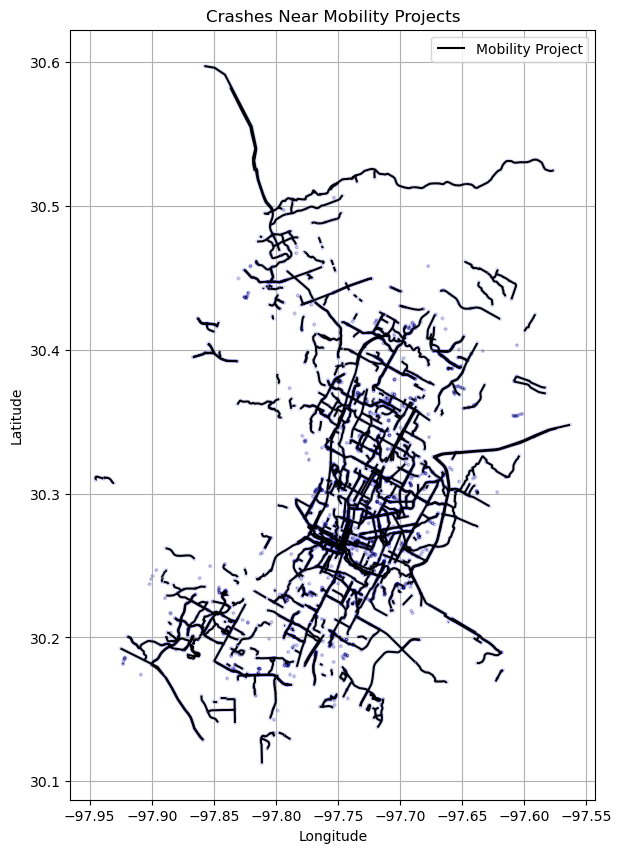

In [32]:
# Plot the mobility projects and crashes on a static map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered geometries (mobility projects)
buffered_moped_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, alpha=0.15, label='Mobility Project Buffers')

# Plot the original line geometries (mobility projects)
gdf_moped.plot(ax=ax, color='black', label='Mobility Project')

# Plot the crash data points
# crashes_near_projects.plot(ax=ax, color='red', markersize=5, label='Crashes within Buffer')

# Enhance the plot with titles and legend
ax.set_title('Crashes Near Mobility Projects')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

In [33]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338261 entries, 0 to 415149
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   crash_id                               338261 non-null  int64              
 1   crash_fatal_fl                         338261 non-null  object             
 2   crash_date                             338261 non-null  object             
 3   rpt_latitude                           24916 non-null   float64            
 4   rpt_longitude                          24916 non-null   float64            
 5   road_constr_zone_fl                    338261 non-null  object             
 6   latitude                               338261 non-null  float64            
 7   longitude                              338261 non-null  float64            
 8   tot_injry_cnt                          338261 non-null  float64            
 9 

In [34]:
crashes_near_projects.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,...,moped_component_id,project_id,project_component_id,geometry_right,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,crash_project_component_id
0,13118092,N,2013-01-25,NaN,NaN,N,30.430933,-97.700708,1.0,0.0,...,200,652,859.0,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265...",2008-01-01 06:00:00+00:00,NaT,NaT,NaT,13118092-652-859.0
725,18407113,N,2021-08-08,NaN,NaN,N,30.430795,-97.700740,0.0,0.0,...,200,652,859.0,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265...",2008-01-01 06:00:00+00:00,NaT,NaT,NaT,18407113-652-859.0
1497,13306837,N,2012-12-31,30.43244,-97.70052,N,30.430783,-97.700758,0.0,0.0,...,200,652,859.0,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265...",2008-01-01 06:00:00+00:00,NaT,NaT,NaT,13306837-652-859.0
3258,13018929,N,2012-12-01,NaN,NaN,N,30.430618,-97.700812,0.0,0.0,...,200,652,859.0,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265...",2008-01-01 06:00:00+00:00,NaT,NaT,NaT,13018929-652-859.0
5490,18797163,N,2022-03-14,NaN,NaN,N,30.429470,-97.695959,1.0,0.0,...,200,652,859.0,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265...",2008-01-01 06:00:00+00:00,NaT,NaT,NaT,18797163-652-859.0


# Analysis

In [35]:
# Converting crash date to datetime format
crashes_near_projects['crash_date'] = pd.to_datetime(crashes_near_projects['crash_date']).dt.tz_localize('UTC', nonexistent='NaT', ambiguous='NaT')

In [36]:
# Converting crash date to datetime format
crashes_near_projects['crash_date'] = pd.to_datetime(crashes_near_projects['crash_date']).dt.tz_convert('UTC')

In [37]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338261 entries, 0 to 415149
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   crash_id                               338261 non-null  int64              
 1   crash_fatal_fl                         338261 non-null  object             
 2   crash_date                             338261 non-null  datetime64[ns, UTC]
 3   rpt_latitude                           24916 non-null   float64            
 4   rpt_longitude                          24916 non-null   float64            
 5   road_constr_zone_fl                    338261 non-null  object             
 6   latitude                               338261 non-null  float64            
 7   longitude                              338261 non-null  float64            
 8   tot_injry_cnt                          338261 non-null  float64            
 9 

In [38]:
# Dropping columns
crashes_near_projects.drop(columns=['rpt_latitude', 
                                    'rpt_longitude', 
                                    'substantial_completion_date_estimated', 
                                    'completion_date', 
                                    'completion_end_date'], inplace=True)

In [39]:
# Re-arranging columns
# First column is the unique identifier for each observation
crashes_near_projects.insert(0, 'crash_project_component_id', crashes_near_projects.pop('crash_project_component_id'))

# moped_component_id
crashes_near_projects.insert(2, 'moped_component_id', crashes_near_projects.pop('moped_component_id'))

# crash_date
crashes_near_projects.insert(4, 'crash_date', crashes_near_projects.pop('crash_date'))

# project compoenent ID
crashes_near_projects.insert(3, 'project_component_id', crashes_near_projects.pop('project_component_id'))

# Substantial completion date
crashes_near_projects.insert(5, 'substantial_completion_date', crashes_near_projects.pop('substantial_completion_date'))


In [40]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338261 entries, 0 to 415149
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   crash_project_component_id   338261 non-null  object             
 1   crash_id                     338261 non-null  int64              
 2   moped_component_id           338261 non-null  int64              
 3   project_component_id         338261 non-null  float64            
 4   crash_fatal_fl               338261 non-null  object             
 5   substantial_completion_date  338261 non-null  datetime64[ns, UTC]
 6   crash_date                   338261 non-null  datetime64[ns, UTC]
 7   road_constr_zone_fl          338261 non-null  object             
 8   latitude                     338261 non-null  float64            
 9   longitude                    338261 non-null  float64            
 10  tot_injry_cnt                338261 n

In [41]:
# Creating indicator variables for crash occuring pre and post completion of mobility project
crashes_near_projects.insert(7, 'crash_pre_completion', crashes_near_projects['crash_date'] < crashes_near_projects['substantial_completion_date'])
crashes_near_projects.insert(8, 'crash_post_completion', crashes_near_projects['crash_date'] > crashes_near_projects['substantial_completion_date'])

In [42]:
# Creating time difference variables
crashes_near_projects.insert(9, 'crash_project_date_diff', crashes_near_projects['substantial_completion_date'] - crashes_near_projects['crash_date'])

In [43]:
crashes_near_projects.head()

,crash_project_component_id,crash_id,moped_component_id,project_component_id,crash_fatal_fl,substantial_completion_date,crash_date,crash_pre_completion,crash_post_completion,crash_project_date_diff,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,geometry_left,index_right,project_id,geometry_right,line_geometry
0,13118092-652-859.0,13118092,200,859.0,N,2008-01-01 06:00:00+00:00,2013-01-25 00:00:00+00:00,False,True,-1851 days +06:00:00,N,30.430933,-97.700708,1.0,0.0,POINT (-97.70071 30.43093),891,652,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265..."
725,18407113-652-859.0,18407113,200,859.0,N,2008-01-01 06:00:00+00:00,2021-08-08 00:00:00+00:00,False,True,-4968 days +06:00:00,N,30.430795,-97.700740,0.0,0.0,POINT (-97.70074 30.43080),891,652,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265..."
1497,13306837-652-859.0,13306837,200,859.0,N,2008-01-01 06:00:00+00:00,2012-12-31 00:00:00+00:00,False,True,-1826 days +06:00:00,N,30.430783,-97.700758,0.0,0.0,POINT (-97.70076 30.43078),891,652,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265..."
3258,13018929-652-859.0,13018929,200,859.0,N,2008-01-01 06:00:00+00:00,2012-12-01 00:00:00+00:00,False,True,-1796 days +06:00:00,N,30.430618,-97.700812,0.0,0.0,POINT (-97.70081 30.43062),891,652,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265..."
5490,18797163-652-859.0,18797163,200,859.0,N,2008-01-01 06:00:00+00:00,2022-03-14 00:00:00+00:00,False,True,-5186 days +06:00:00,N,30.429470,-97.695959,1.0,0.0,POINT (-97.69596 30.42947),891,652,"MULTILINESTRING ((-97.68123 30.42837, -97.6824...","MULTILINESTRING ((626647.799 3366991.674, 6265..."


In [44]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338261 entries, 0 to 415149
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   crash_project_component_id   338261 non-null  object             
 1   crash_id                     338261 non-null  int64              
 2   moped_component_id           338261 non-null  int64              
 3   project_component_id         338261 non-null  float64            
 4   crash_fatal_fl               338261 non-null  object             
 5   substantial_completion_date  338261 non-null  datetime64[ns, UTC]
 6   crash_date                   338261 non-null  datetime64[ns, UTC]
 7   crash_pre_completion         338261 non-null  bool               
 8   crash_post_completion        338261 non-null  bool               
 9   crash_project_date_diff      338261 non-null  timedelta64[ns]    
 10  road_constr_zone_fl          338261 n

In [45]:
# Function to calculate duration in years
def calculate_duration(df, date_col1, date_col2):
    duration = (df[date_col2] - df[date_col1]).dt.total_seconds() / (365.25 * 24 * 3600)
    return duration

crashes_near_projects['pre_completion_duration'] = crashes_near_projects['crash_pre_completion'] * calculate_duration(crashes_near_projects, 'crash_date', 'substantial_completion_date')
crashes_near_projects['post_completion_duration'] = crashes_near_projects['crash_post_completion'] * calculate_duration(crashes_near_projects, 'substantial_completion_date', 'crash_date')

In [47]:
pre_completion_stats = crashes_near_projects[crashes_near_projects['crash_pre_completion']].groupby('moped_component_id').agg({
    'crash_id': 'count',
    'pre_completion_duration': 'sum'
}).rename(columns={'crash_id': 'pre_crash_count'}).reset_index()

post_completion_stats = crashes_near_projects[crashes_near_projects['crash_post_completion']].groupby('moped_component_id').agg({
    'crash_id': 'count',
    'post_completion_duration': 'sum'
}).rename(columns={'crash_id': 'post_crash_count'}).reset_index()


In [48]:
annualized_crash_rate = pre_completion_stats.merge(post_completion_stats, on='moped_component_id', how='outer').fillna(0)

annualized_crash_rate['pre_annualized_crash_rate'] = annualized_crash_rate['pre_crash_count'] / annualized_crash_rate['pre_completion_duration']
annualized_crash_rate['post_annualized_crash_rate'] = annualized_crash_rate['post_crash_count'] / annualized_crash_rate['post_completion_duration']

In [51]:
# Getting completion date for each moped component id
completion_dates = crashes_near_projects.groupby('moped_component_id')['substantial_completion_date'].first().reset_index()

# Merging into the annualized crash rate DataFrame
annualized_crash_rate = annualized_crash_rate.merge(completion_dates, on='moped_component_id', how='left')

In [57]:
annualized_crash_rate = annualized_crash_rate[['moped_component_id', 'substantial_completion_date_x', 'pre_annualized_crash_rate', 'post_annualized_crash_rate']]

In [58]:
annualized_crash_rate

,moped_component_id,substantial_completion_date_x,pre_annualized_crash_rate,post_annualized_crash_rate
0,1,2022-10-10 05:00:00+00:00,0.140613,0.951688
1,2,2022-10-10 05:00:00+00:00,0.181301,1.179018
2,3,2022-10-10 05:00:00+00:00,0.170834,1.117001
3,4,2022-10-10 05:00:00+00:00,0.159645,1.058951
4,5,2022-10-10 05:00:00+00:00,0.183909,1.282516
...,...,...,...,...
2177,2447,1999-01-01 06:00:00+00:00,NaN,0.052436
2178,2528,2022-02-28 06:00:00+00:00,NaN,4.259475
2179,2544,2022-03-31 05:00:00+00:00,NaN,0.513142
2180,2605,2022-11-01 05:00:00+00:00,NaN,0.670440


In [61]:
annualized_crash_rate.to_csv('annualized_crash_rate.csv')

In [60]:
# Checking rows where there are NaN values for pre_annualized_crash_rate
crashes_near_projects.loc[crashes_near_projects['moped_component_id'] == 2528]

,crash_project_component_id,crash_id,moped_component_id,project_component_id,crash_fatal_fl,substantial_completion_date,crash_date,crash_pre_completion,crash_post_completion,crash_project_date_diff,...,longitude,tot_injry_cnt,death_cnt,geometry_left,index_right,project_id,geometry_right,line_geometry,pre_completion_duration,post_completion_duration
228714,18939092-3314-11442.0,18939092,2528,11442.0,N,2022-02-28 06:00:00+00:00,2022-05-25 00:00:00+00:00,False,True,-86 days +06:00:00,...,-97.656184,1.0,0.0,POINT (-97.65618 30.37509),11517,3314,MULTIPOINT (-97.65579 30.37422),"LINESTRING (629169.708 3361018.889, 629169.573...",-0.0,0.234771


In [194]:
min_crash_date = crashes_near_projects['crash_date'].min()
min_crash_date

Timestamp('2010-01-01 00:00:00+0000', tz='UTC')

In [62]:
annualized_crash_rate_filter = annualized_crash_rate[annualized_crash_rate.notna().all(axis=1)]

In [64]:
annualized_crash_rate_filter
annualized_crash_rate_filter.to_csv('annualized_crash_rate_filter.csv')

In [65]:
annualized_crash_rate_filter

,moped_component_id,substantial_completion_date_x,pre_annualized_crash_rate,post_annualized_crash_rate
0,1,2022-10-10 05:00:00+00:00,0.140613,0.951688
1,2,2022-10-10 05:00:00+00:00,0.181301,1.179018
2,3,2022-10-10 05:00:00+00:00,0.170834,1.117001
3,4,2022-10-10 05:00:00+00:00,0.159645,1.058951
4,5,2022-10-10 05:00:00+00:00,0.183909,1.282516
...,...,...,...,...
2026,2660,2020-03-01 06:00:00+00:00,0.213544,0.471184
2027,2661,2020-03-01 06:00:00+00:00,0.193346,0.458033
2031,2665,2020-02-01 06:00:00+00:00,0.129897,0.231207
2034,2668,2020-09-01 05:00:00+00:00,0.254581,2.689782


In [66]:
annualized_crash_rate_filter['pre_annualized_crash_rate'].mean()

0.6575195341563087

In [67]:
annualized_crash_rate_filter['post_annualized_crash_rate'].mean()

0.9142756354679507